In [1]:
import sys
import os

# Add the parent directory to the path so Python can find the toolbox package
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added {module_path} to sys.path")

Added e:\repo\DistilBERTFinancialSentiment to sys.path


In [2]:
import torch

# Check CUDA availability
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA current device: {torch.cuda.current_device()}")
    # Set deterministic behavior for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    print("WARNING: CUDA is not available. Training will be much slower on CPU.")


CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 4070
CUDA current device: 0


In [3]:
import torch

# Create weight tensor and move it to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
model_name = 'distilroberta-roberta-finetuned-financial-news-sentiment-analysis-european'

In [5]:
import wandb

wandb.login()

wandb: Currently logged in as: nestorojedagonzalez (nojeda) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert/distilroberta-base', num_labels=3)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [7]:
# ── label map ────────────────────────────────────────────────────────────────
# Keep this next to your tokenizer/model init so everything shares the same map
label2id = {"neutral": 0, "positive": 1, "negative": 2}
id2label = {v: k for k, v in label2id.items()}

In [8]:
from datasets import load_dataset

dataset = load_dataset("nojedag/financial_phrasebank_multilingual_augmented")

def filter_by_token_length(example):
    tokens = tokenizer.tokenize(example['sentence'])
    return len(tokens) <= 512

def prepare_dataset(dataset):
    # dataset = dataset.filter(lambda example: filter_by_token_length(example))
    return dataset

dataset = prepare_dataset(dataset)

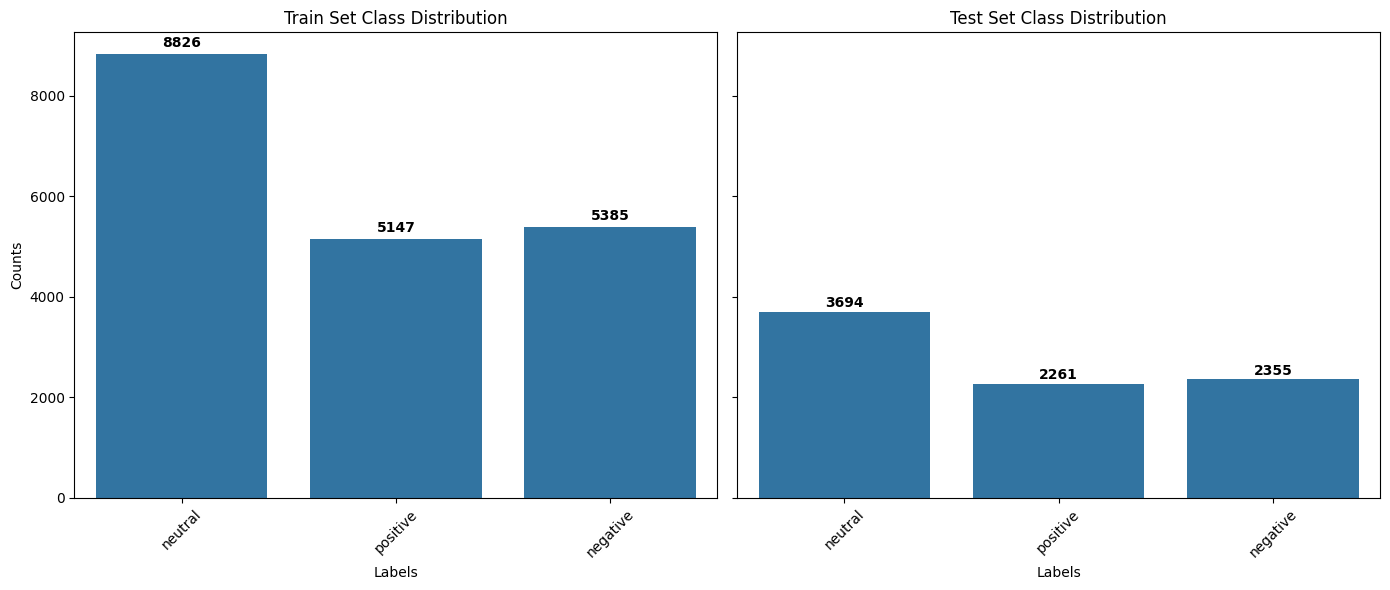

In [9]:
# EDA
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(dataset):
    unique_labels = sorted(set(dataset['train']['labels']))
    train_counts = [dataset['train'].filter(lambda x: x['labels'] == i).num_rows for i in unique_labels]
    test_counts = [dataset['test'].filter(lambda x: x['labels'] == i).num_rows for i in unique_labels]
    label_names = [id2label[i] for i in unique_labels]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    # Train set
    ax = axes[0]
    sns.barplot(x=label_names, y=train_counts, ax=ax)
    ax.set_title('Train Set Class Distribution')
    ax.set_xlabel('Labels')
    ax.set_ylabel('Counts')
    ax.set_xticks(range(len(label_names)))
    ax.set_xticklabels(label_names, rotation=45)
    for i, count in enumerate(train_counts):
        ax.text(i, count + max(train_counts)*0.01, str(count), ha='center', va='bottom', fontweight='bold')
    
    # Test set
    ax = axes[1]
    sns.barplot(x=label_names, y=test_counts, ax=ax)
    ax.set_title('Test Set Class Distribution')
    ax.set_xlabel('Labels')
    ax.set_ylabel('Counts')
    ax.set_xticks(range(len(label_names)))
    ax.set_xticklabels(label_names, rotation=45)
    for i, count in enumerate(test_counts):
        ax.text(i, count + max(test_counts)*0.01, str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

plot_class_distribution(dataset)


In [10]:
# let's tokenize the data for the model to be able to understand
def tokenize_data(example):
    return tokenizer(example['sentence'], padding='max_length', truncation=True)    

In [11]:
# Tokenize the dataset
dataset = dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/19358 [00:00<?, ? examples/s]

Map:   0%|          | 0/8310 [00:00<?, ? examples/s]

In [12]:
from transformers import AutoModelForSequenceClassification

# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilroberta-base", num_labels=3)
# Explicitly move model to the correct device
model = model.to(device)
print(f"Model moved to {device}")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model moved to cuda


In [13]:
# the default batch size for training arguments
batch_size = 16

# set number of epochs
number_of_epochs = 7
# let set the logging steps
logging_steps = len(dataset['train']) // batch_size # it should log each batch 

steps = (len(dataset['train']) / batch_size) * number_of_epochs
warmup_steps = int(0.1 * steps)

In [14]:
import torch
from transformers import Trainer

class CustomTrainer(Trainer):
    """
    Custom Trainer that supports weighted loss for class imbalance and robust device handling.
    """
    def __init__(self, weight_tensor, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.original_weight_tensor = weight_tensor
        self.loss_fct = torch.nn.CrossEntropyLoss(weight=weight_tensor.to(self.model.device))

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # Ensure the loss function's weight tensor is on the same device as the model
        device = self.model.device
        if hasattr(self.loss_fct, 'weight') and self.loss_fct.weight is not None:
            if self.loss_fct.weight.device != device or self.loss_fct.weight.dtype != self.original_weight_tensor.dtype:
                self.loss_fct = torch.nn.CrossEntropyLoss(
                    weight=self.original_weight_tensor.to(device=device, dtype=self.original_weight_tensor.dtype)
                )

        labels = inputs.get("labels")
        if labels is None:
            raise ValueError("Labels must be present in the inputs for loss computation.")
        # Do not pop labels, just use them
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.get("logits") if isinstance(outputs, dict) else outputs[0]
        labels = labels.to(device)
        loss = self.loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [15]:
import numpy as np
from typing import Dict, Any
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ── metric function for Trainer ──────────────────────────────────────────────
def compute_metrics(eval_pred) -> Dict[str, Any]:
    """
    Sentiment‑specific compute_metrics for 3‑way classification.
    
    Returns overall accuracy + macro P/R/F1 *and* per‑class precision/recall/F1,
    all as flat keys so Trainer logs cleanly.
    """
    # A. unpack
    logits, labels = eval_pred
    labels = labels.astype(int)

    # B. post‑process: softmax → argmax
    preds = np.argmax(logits, axis=-1)

    # C. overall metrics
    accuracy = accuracy_score(labels, preds)
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )

    # D. per‑class metrics
    # precision_recall_fscore_support returns arrays ordered by the label ids we pass
    p_cls, r_cls, f1_cls, _ = precision_recall_fscore_support(
        labels, preds, labels=list(id2label.keys()), zero_division=0
    )

    per_class = {}
    for idx, cls_name in id2label.items():
        per_class[f"{cls_name}_precision"] = p_cls[idx]
        per_class[f"{cls_name}_recall"]    = r_cls[idx]
        per_class[f"{cls_name}_f1"]        = f1_cls[idx]

    # E. flatten & return
    return {
        "accuracy": accuracy,
        "macro_precision": p_macro,
        "macro_recall": r_macro,
        "macro_f1": f1_macro,
        **per_class,
    }


In [16]:
train_dataset = dataset['train'].shuffle(seed=42) 
eval_dataset = dataset['test'].shuffle(seed=42)

In [17]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8) # pad to 8 for GPU efficiency

In [18]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    num_train_epochs=number_of_epochs, 
    load_best_model_at_end=True,
    eval_strategy='steps',  # (updated: 'eval_strategy' is deprecated)
    save_strategy='steps',
    learning_rate=2e-5,  
    weight_decay=0.01,
    logging_steps=logging_steps,
    warmup_steps=warmup_steps,
    save_steps=1000,
    eval_steps=500,
    output_dir=f".././models/{model_name}",
    run_name=model_name,
    report_to="wandb",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=2,
    fp16=True,
    no_cuda=False,
    dataloader_pin_memory=True,
    seed=42,  # Ensures reproducibility
    dataloader_num_workers=4,  # Speeds up data loading (adjust for your CPU)
    save_total_limit=2,  # Limits number of checkpoints to save disk space
    metric_for_best_model="macro_f1",  # Use your main metric for best model selection
    greater_is_better=True,  # Set according to your metric
    logging_first_step=True,  # Log the first step for early diagnostics
    disable_tqdm=False,  # Show progress bar
    remove_unused_columns=True,  # Speeds up training if you don't need extra columns
)

In [19]:

# Print device information for training
print(f"Training will use device: {'CUDA' if not training_args.no_cuda and torch.cuda.is_available() else 'CPU'}")
print(f"FP16 (mixed precision): {training_args.fp16}")
print(f"Batch size per device: {training_args.per_device_train_batch_size}")
print(f"Gradient accumulation steps: {training_args.gradient_accumulation_steps}")
print(f"Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps * (torch.cuda.device_count() if torch.cuda.is_available() else 1)}")

Training will use device: CUDA
FP16 (mixed precision): True
Batch size per device: 16
Gradient accumulation steps: 2
Effective batch size: 32


In [20]:
from transformers import Trainer

from collections import Counter

labels = dataset['train']['labels']
counts = Counter(labels)
total = sum(counts.values())
weights = torch.tensor([total/counts[i] for i in range(3)], dtype=torch.float)
weights = weights / weights.sum()  # normalize
for labels, weight in zip(range(3), weights):
    print(f"Label {id2label[labels]}: {weight.item():.4f} (count: {counts[labels]})")

Label neutral: 0.2297 (count: 8826)
Label positive: 0.3939 (count: 5147)
Label negative: 0.3765 (count: 5385)


In [21]:
from transformers import EarlyStoppingCallback

# weights is already a tensor, just use it directly
weight_tensor = weights.to(device)

trainer = CustomTrainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset, 
    weight_tensor=weight_tensor, data_collator=data_collator, compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)


In [22]:
# Function to monitor GPU memory usage
def print_gpu_memory_stats():
    if torch.cuda.is_available():
        # Get the current GPU index
        current_device = torch.cuda.current_device()
        
        # Reserved memory in GB
        reserved = torch.cuda.memory_reserved(current_device) / 1e9
        
        # Allocated memory in GB
        allocated = torch.cuda.memory_allocated(current_device) / 1e9
        
        # Max allocated memory in GB
        max_allocated = torch.cuda.max_memory_allocated(current_device) / 1e9
        
        # Get total memory in GB
        total = torch.cuda.get_device_properties(current_device).total_memory / 1e9
        
        print(f"GPU Memory: Total: {total:.2f} GB | Reserved: {reserved:.2f} GB | Allocated: {allocated:.2f} GB | Max Allocated: {max_allocated:.2f} GB")
    else:
        print("GPU is not available.")

# Print memory status before creating trainer
print("GPU memory before creating trainer:")
print_gpu_memory_stats()

GPU memory before creating trainer:
GPU Memory: Total: 12.88 GB | Reserved: 0.37 GB | Allocated: 0.33 GB | Max Allocated: 0.33 GB


In [23]:
# Start training
print("Starting training...")
trainer.train()

# Print memory usage after training
print("\nTraining completed. GPU memory usage:")
print_gpu_memory_stats()

Starting training...


Step,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1,Neutral Precision,Neutral Recall,Neutral F1,Positive Precision,Positive Recall,Positive F1,Negative Precision,Negative Recall,Negative F1
500,1.145300,0.817492,0.579302,0.635997,0.595104,0.574500,0.812072,0.513535,0.629187,0.424085,0.830164,0.561388,0.671835,0.441614,0.532923
1000,1.145300,0.701206,0.696270,0.709202,0.702092,0.691069,0.837345,0.659177,0.737655,0.727031,0.605484,0.660714,0.563228,0.841614,0.674838
1500,0.789900,0.623898,0.741757,0.734955,0.744444,0.737330,0.828096,0.727666,0.774640,0.715503,0.743034,0.729008,0.661267,0.762633,0.708342
2000,0.789900,0.622902,0.762214,0.762583,0.769408,0.760239,0.854994,0.723064,0.783514,0.777573,0.745245,0.761066,0.655184,0.839915,0.736137
2500,0.435200,0.782535,0.703971,0.727395,0.729802,0.703017,0.899083,0.583649,0.707814,0.572905,0.931446,0.709449,0.710197,0.674310,0.691788
3000,0.435200,0.633908,0.766185,0.764222,0.781247,0.766038,0.874658,0.691391,0.772301,0.738431,0.832817,0.782789,0.679577,0.819533,0.743022
3500,0.435200,0.670779,0.773887,0.769350,0.782469,0.772965,0.848980,0.731998,0.786161,0.769772,0.822203,0.795124,0.689299,0.793206,0.737611
4000,0.288500,0.670896,0.776414,0.773672,0.786511,0.776183,0.856869,0.726042,0.786049,0.781488,0.817780,0.799222,0.682658,0.815711,0.743277



Training completed. GPU memory usage:
GPU Memory: Total: 12.88 GB | Reserved: 3.41 GB | Allocated: 1.01 GB | Max Allocated: 3.26 GB


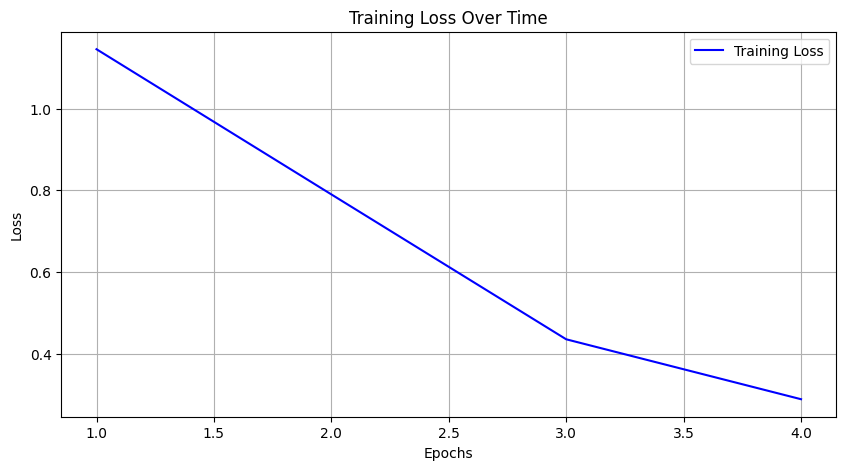

In [24]:
# Plot training loss
import matplotlib.pyplot as plt
import numpy as np

def plot_training_loss(trainer):
    """
    Plot the training loss over time.
    
    Args:
        trainer: The Trainer object containing training history.
    """
    # Extract the training loss values
    train_loss = trainer.state.log_history

    # Filter for training loss entries
    train_loss = [entry['loss'] for entry in train_loss if 'loss' in entry]

    # Create an array of epochs
    epochs = np.arange(1, len(train_loss) + 1)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label='Training Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.grid()
    plt.show()

plot_training_loss(trainer)

In [25]:
trainer_eval = Trainer(
    model=model.to(device),  # Ensure model is on the correct device
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics
)
print(f"Evaluation trainer using device: {next(model.parameters()).device}")

Evaluation trainer using device: cuda:0


In [26]:
trainer_eval.evaluate()

{'eval_loss': 0.6636907458305359,
 'eval_model_preparation_time': 0.0015,
 'eval_accuracy': 0.7764139590854392,
 'eval_macro_precision': 0.7736716301642957,
 'eval_macro_recall': 0.7865110755915179,
 'eval_macro_f1': 0.7761828085646667,
 'eval_neutral_precision': 0.8568690095846645,
 'eval_neutral_recall': 0.7260422306442881,
 'eval_neutral_f1': 0.7860492379835874,
 'eval_positive_precision': 0.7814877430262046,
 'eval_positive_recall': 0.8177797434763379,
 'eval_positive_f1': 0.799221958072185,
 'eval_negative_precision': 0.6826581378820185,
 'eval_negative_recall': 0.8157112526539279,
 'eval_negative_f1': 0.7432772296382278,
 'eval_runtime': 18.4835,
 'eval_samples_per_second': 449.589,
 'eval_steps_per_second': 28.133}

In [27]:
eval_output = trainer_eval.predict(eval_dataset)
logits = eval_output.predictions  # shape (N_examples, N_labels)
labels = eval_output.label_ids     # shape (N_examples,)

preds = np.argmax(logits, axis=1)

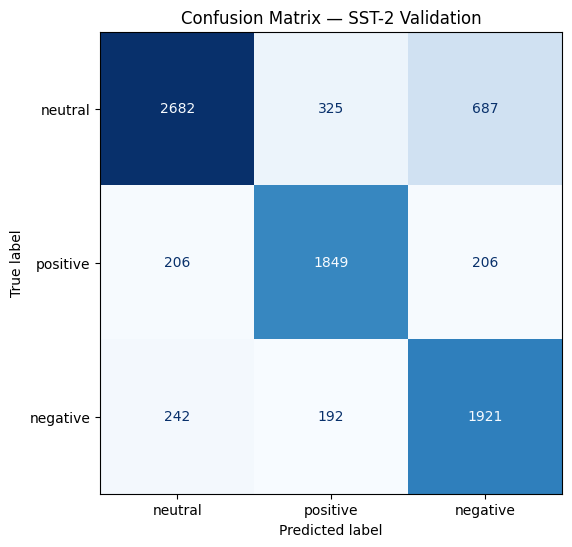

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, preds)

display_labels = ["neutral", "positive", "negative"]  # Based on label_map in transform_labels
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=display_labels
)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix — SST-2 Validation")
plt.show()

In [29]:
# If you want to push to the hub, uncomment this line
model.push_to_hub(f'nojedag/{model_name}')
trainer.push_to_hub()
trainer_eval.push_to_hub()

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.91k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/nojedag/distilroberta-roberta-finetuned-financial-news-sentiment-analysis-european/commit/ab514e1c86d6f5aea0d368eacb330f22d1fc92cd', commit_message='End of training', commit_description='', oid='ab514e1c86d6f5aea0d368eacb330f22d1fc92cd', pr_url=None, repo_url=RepoUrl('https://huggingface.co/nojedag/distilroberta-roberta-finetuned-financial-news-sentiment-analysis-european', endpoint='https://huggingface.co', repo_type='model', repo_id='nojedag/distilroberta-roberta-finetuned-financial-news-sentiment-analysis-european'), pr_revision=None, pr_num=None)

In [30]:
wandb.finish()

eval/accuracy,▁▅▇▇▅████
eval/loss,█▄▁▁▇▁▃▃▂
eval/macro_f1,▁▅▇▇▅████
eval/macro_precision,▁▅▆▇▆████
eval/macro_recall,▁▅▆▇▆████
eval/model_preparation_time,▁
eval/negative_f1,▁▆▇█▆████
eval/negative_precision,▆▁▆▅█▇▇▇▇
eval/negative_recall,▁█▇█▅█▇██
eval/neutral_f1,▁▆▇█▅▇███
eval/neutral_precision,▁▃▂▄█▆▄▅▅
